# 기본 시각화 및 전처리
데이터 가져와서 결측값 삭제하고 자료형 변환  
이후 연도별 Frequency를 시각화

In [1]:
import datetime as dt
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser as dtparser

import utils

plt.rc('font', family="Malgun Gothic")

In [2]:
keywords = {}
keywords["kin"] = ["환자 권리", "환자 요구", "환자 의견"]
keywords["news"] = []
keywords["news_api"] = ["환자-의사 공유 의사결정"]
keywords["news_crawl"] = ["환자 의사 공유의사결정"]
keywords["news_unique"] = [""]

filenames = {}
filenames["kin"] = utils.FileType.KIN_WT.value
filenames["news"] = ""
filenames["news_api"] = utils.FileType.NEWS_WT.value
filenames["news_crawl"] = utils.FileType.CRAWL_NEWS_WT.value
filenames["news_unique"] = utils.FileType.NEWS_PROCESSED_UNIQUE.value

source_types = ["news_api", "news_crawl", "kin", "news_unique"]

In [3]:
# get df

dfs = {}
for source_type in source_types:
    dfs[source_type] = {}
    for keyword in keywords[source_type]:
        filename = f'{filenames[source_type]}_{keyword}.txt' if keyword else f'{filenames[source_type]}.txt'
        data_json = utils.get_json_from_file(filename)["items"]
        dfs[source_type][keyword] = pd.DataFrame(data_json)

In [4]:
# preprocessing df

source_type = "news_api"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["date"] = pd.to_datetime(df["date"])
    df = df[~df["text"].str.endswith("_error")]
    dfs[source_type][keyword] = df

source_type = "news_crawl"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["date"] = pd.to_datetime(df["date"])
    df = df[~df["text"].str.endswith("_error")]
    dfs[source_type][keyword] = df

def dtparse(s: str):
    if s.startswith("작성일"):
        s = s[3:]
    try:
        return dtparser.parse(s)
    except dtparser.ParserError:
        return None

source_type = "kin"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["date"] = df["date"].apply(lambda x: list(map(lambda y: dtparse(y), x)))
    dfs[source_type][keyword] = df

source_type = "news_unique"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    date_1 = df["date"][:349]
    date_2 = df["date"][349:]
    df["date"] = pd.concat([pd.to_datetime(date_1).dt.tz_localize(None), pd.to_datetime(date_2)])
    df["date"] = pd.to_datetime(df["date"])
    df = df[df["tokens"].apply(lambda x: len(x) > 0)]
    dfs[source_type][keyword] = df


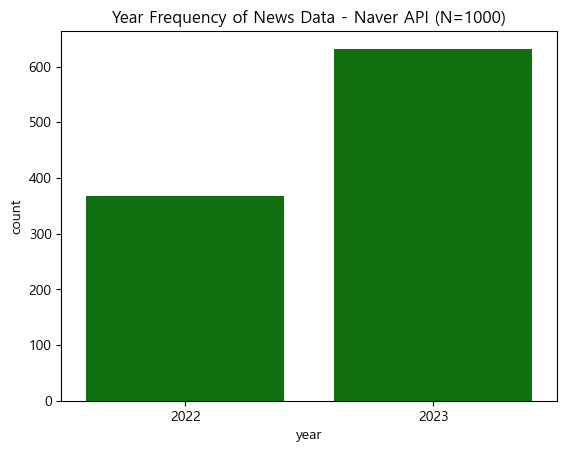

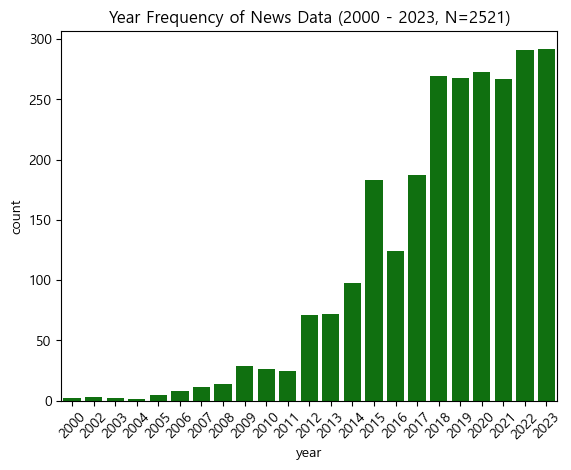

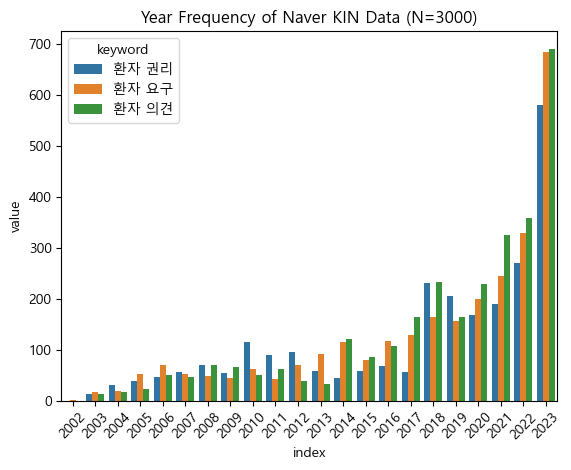

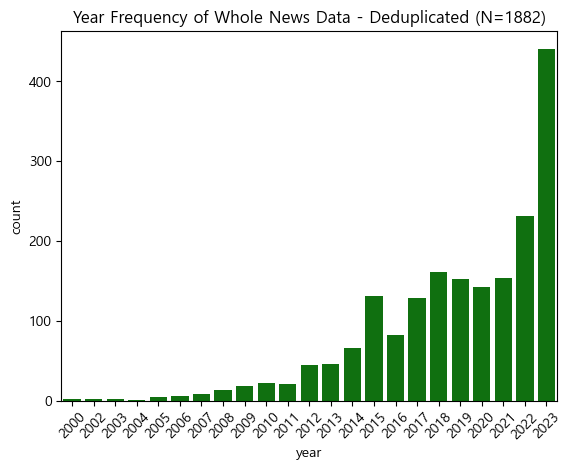

In [5]:
# basic year freq

source_type = "news_api"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["year"] = df["date"].dt.year
    sns.countplot(data=df, x="year", color="green")
    plt.title(f"Year Frequency of News Data - Naver API (N={len(df)})")
    plt.show()

source_type = "news_crawl"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["year"] = df["date"].dt.year
    sns.countplot(data=df, x="year", color="green")
    plt.title(f"Year Frequency of News Data (2000 - 2023, N={len(df)})")
    plt.xticks(rotation=45)
    plt.show()

source_type = "kin"
temp_n = 0
year_dict = dict(zip(keywords[source_type], [defaultdict(int) for _ in keywords[source_type]]))
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    temp_n += len(df)
    for row in df["date"]:
        for date in row:
            if date is None:
                continue
            year_dict[keyword][date.year] += 1

df_temp = pd.melt(pd.DataFrame(year_dict).reset_index(), id_vars='index', var_name='column', value_name='value')
sns.barplot(data=df_temp, x='index', y='value', hue='column')
plt.title(f"Year Frequency of Naver KIN Data (N={temp_n})")
plt.xticks(rotation=45)
plt.legend(title = "keyword")
plt.show()

source_type = "news_unique"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["year"] = df["date"].dt.year
    sns.countplot(data=df, x="year", color="green")
    plt.title(f"Year Frequency of Whole News Data - Deduplicated (N={len(df)})")
    plt.xticks(rotation=45)
    plt.show()

# 토픽 모델링
LLM(Large Language Model) ChatGPT 이용하여 일부 분류한 데이터를 활용, BERTopic으로 Semi-Supervised Learning을 수행

In [6]:
from bertopic import BERTopic
from mecab import MeCab
from sklearn.feature_extraction.text import CountVectorizer

import utils

d:\Codes\SDM_crawl\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
df = dfs["news_unique"][""]
n = len(df)
mecab = MeCab()

def tokenize_nouns(text):
    return mecab.nouns(text)
vectorizer = CountVectorizer(tokenizer=tokenize_nouns)

docs = df["text"]
indices = utils.get_json_from_file(f"{utils.MATERIALS}/naver_news_topics.txt")["indices"]
y = [1 if i in indices else -1 for i in range(n)]
topic_model = BERTopic(verbose=True, language="multilingual", vectorizer_model=vectorizer).fit(docs, y=y)

2023-12-19 03:51:32,175 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 59/59 [07:19<00:00,  7.44s/it]
2023-12-19 03:58:58,649 - BERTopic - Embedding - Completed ✓
2023-12-19 03:58:58,650 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2023-12-19 03:59:18,411 - BERTopic - Dimensionality - Completed ✓
2023-12-19 03:59:18,425 - BERTopic - Cluster - Start clustering the reduced embeddings
2023-12-19 03:59:18,720 - BERTopic - Cluster - Completed ✓
2023-12-19 03:59:18,752 - BERTopic - Representation - Extracting topics from clusters using representation models.


In [10]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,1756,0_10_19_ai_20,"[10, 19, ai, 20, 11, 12, 30, 2022, 2023, the]",[\n\n보건복지부(장관 조규홍)가 바이오헬스 및 디지털 헬스케어 육성방안을 마련하...
1,1,101,1_ai_ibm_gpt_ml,"[ai, ibm, gpt, ml, lg, it, sas, data, db, bi]","[㈜토마토헬스케어-요타코퍼레이션(주) 전략적 제휴광주상의, 4차 산업혁명 대응 혁신..."
2,2,13,2_iot_rtls_aiot_data,"[iot, rtls, aiot, data, hpe, rfid, it, ai, iom...",[\n[테크월드뉴스=서용하 기자] IoT(사물인터넷)가 다양한 산업 분야의 효율성과...
3,3,12,3_ceo_kb_mayo_ms,"[ceo, kb, mayo, ms, clinic, fda, ai, ma, 100, it]",[2010.08.11 11:13\n\n\n\n\n문서\n\n\n프린트\n\n\n글자...
